# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [2]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Extracting mnist: 100%|██████████| 60.0k/60.0k [00:09<00:00, 6.42kFile/s]
  TqdmSynchronisationWarning)


Extracting celeba...


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:278: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '


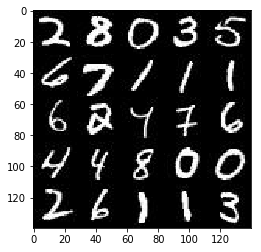

In [4]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

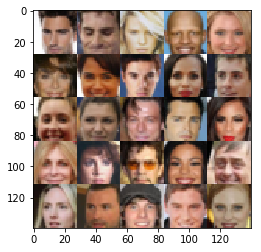

In [5]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.5.1


/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:14: UserWarning: No GPU found. Please use a GPU to train your neural network.


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [11]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_dim=(image_width,image_height,image_channels)
    inputs_real = tf.placeholder(tf.float32, (None, *real_dim), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, name="learning_rate")
    
    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [19]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.2
    with tf.variable_scope('discriminator', reuse=reuse):
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)

        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=1, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)

        #x4 = tf.layers.conv2d(relu2, 512, 5, strides=1, padding='same')
        #bn4 = tf.layers.batch_normalization(x4, training=True)
        #relu4 = tf.maximum(alpha * bn4, bn4)

        # Flatten it
        flat = tf.reshape(relu3, (-1, 7*7*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
    return out, logits

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [20]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    reuse = not is_train
    alpha = 0.2
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*512)

        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        relu1 = tf.maximum(alpha * x1, x1)
        
        x2 = tf.layers.conv2d_transpose(relu1, 256, 5, strides=1, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        relu2 = tf.maximum(alpha * x2, x2)
        # 7x7x256 now

        x3 = tf.layers.conv2d_transpose(relu2, 128, 5, strides=1, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        relu3 = tf.maximum(alpha * x3, x3)
        # 7x7x128 now

        x4 = tf.layers.conv2d_transpose(relu3, 64, 5, strides=2, padding='same')
        x4 = tf.layers.batch_normalization(x4, training=is_train)
        relu4 = tf.maximum(alpha * x4, x4)
        # 14x14x64 now

        # Output layer
        logits = tf.layers.conv2d_transpose(relu4, out_channel_dim, 5, strides=2, padding='same')
        # 28x28xout_channel_dim
        
        out = tf.tanh(logits)
        
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [21]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [22]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [23]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [24]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    print_every = 10
    show_every = 100
    steps = 0
    
    image_width = data_shape[1]
    image_height = data_shape[2]
    if(data_image_mode == 'RGB'):
        image_channels = 3
    else:
        image_channels = 1
    
    input_real, input_z, lr = model_inputs(image_width, image_height, image_channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                
                steps += 1
                batch_images = batch_images.reshape(batch_size, data_shape[1], data_shape[2], data_shape[3])
                batch_images = batch_images * 2
    
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr:learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images, lr:learning_rate})

                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                
                if steps % show_every == 0:
                    show_generator_output(sess, 25, input_z, image_channels, data_image_mode)


### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 2.2977... Generator Loss: 0.1445
Epoch 1/2... Discriminator Loss: 2.4978... Generator Loss: 0.1094
Epoch 1/2... Discriminator Loss: 3.8567... Generator Loss: 0.0246
Epoch 1/2... Discriminator Loss: 2.9658... Generator Loss: 0.0742
Epoch 1/2... Discriminator Loss: 1.4620... Generator Loss: 0.3433
Epoch 1/2... Discriminator Loss: 0.4927... Generator Loss: 3.0380
Epoch 1/2... Discriminator Loss: 1.1021... Generator Loss: 0.5574
Epoch 1/2... Discriminator Loss: 0.8907... Generator Loss: 0.6512
Epoch 1/2... Discriminator Loss: 1.3314... Generator Loss: 0.3768
Epoch 1/2... Discriminator Loss: 0.2559... Generator Loss: 2.1749


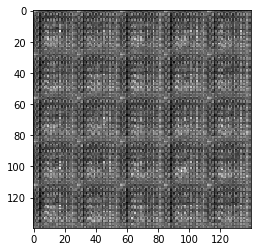

Epoch 1/2... Discriminator Loss: 0.3962... Generator Loss: 1.6749
Epoch 1/2... Discriminator Loss: 1.7321... Generator Loss: 2.0971
Epoch 1/2... Discriminator Loss: 1.3607... Generator Loss: 0.4870
Epoch 1/2... Discriminator Loss: 1.2878... Generator Loss: 0.4191
Epoch 1/2... Discriminator Loss: 0.5723... Generator Loss: 1.4062
Epoch 1/2... Discriminator Loss: 0.8139... Generator Loss: 0.8456
Epoch 1/2... Discriminator Loss: 0.7905... Generator Loss: 0.9745
Epoch 1/2... Discriminator Loss: 1.4312... Generator Loss: 0.3836
Epoch 1/2... Discriminator Loss: 1.7061... Generator Loss: 0.2627
Epoch 1/2... Discriminator Loss: 1.0183... Generator Loss: 1.3758


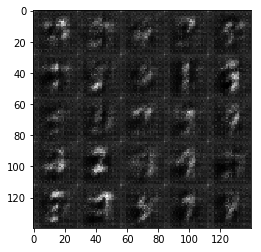

Epoch 1/2... Discriminator Loss: 0.9464... Generator Loss: 1.1547
Epoch 1/2... Discriminator Loss: 1.0648... Generator Loss: 0.5457
Epoch 1/2... Discriminator Loss: 1.0892... Generator Loss: 0.5024
Epoch 1/2... Discriminator Loss: 1.0864... Generator Loss: 0.5445
Epoch 1/2... Discriminator Loss: 0.9985... Generator Loss: 0.6334
Epoch 1/2... Discriminator Loss: 0.8087... Generator Loss: 0.8123
Epoch 1/2... Discriminator Loss: 1.6803... Generator Loss: 0.2370
Epoch 1/2... Discriminator Loss: 0.8194... Generator Loss: 1.4414
Epoch 1/2... Discriminator Loss: 1.2500... Generator Loss: 0.3981
Epoch 1/2... Discriminator Loss: 1.0553... Generator Loss: 0.6503


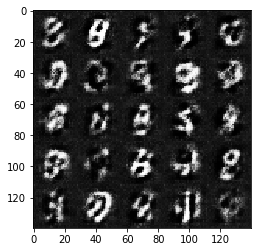

Epoch 1/2... Discriminator Loss: 1.0954... Generator Loss: 2.1010
Epoch 1/2... Discriminator Loss: 1.0816... Generator Loss: 2.2259
Epoch 1/2... Discriminator Loss: 1.0875... Generator Loss: 0.5180
Epoch 1/2... Discriminator Loss: 1.0460... Generator Loss: 0.5814
Epoch 1/2... Discriminator Loss: 0.7644... Generator Loss: 1.4930
Epoch 1/2... Discriminator Loss: 0.7995... Generator Loss: 2.1834
Epoch 1/2... Discriminator Loss: 1.1434... Generator Loss: 2.5336
Epoch 1/2... Discriminator Loss: 0.8455... Generator Loss: 1.5541
Epoch 1/2... Discriminator Loss: 0.7043... Generator Loss: 1.1668
Epoch 1/2... Discriminator Loss: 1.1684... Generator Loss: 0.4578


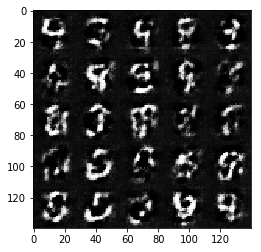

Epoch 1/2... Discriminator Loss: 1.5873... Generator Loss: 0.2914
Epoch 1/2... Discriminator Loss: 0.6735... Generator Loss: 2.1851
Epoch 1/2... Discriminator Loss: 0.8113... Generator Loss: 0.8956
Epoch 1/2... Discriminator Loss: 0.7476... Generator Loss: 1.4252
Epoch 1/2... Discriminator Loss: 0.9279... Generator Loss: 1.0568
Epoch 1/2... Discriminator Loss: 0.9304... Generator Loss: 1.3839
Epoch 1/2... Discriminator Loss: 0.7398... Generator Loss: 1.1292
Epoch 1/2... Discriminator Loss: 0.6704... Generator Loss: 1.0236
Epoch 1/2... Discriminator Loss: 0.7862... Generator Loss: 1.7357
Epoch 1/2... Discriminator Loss: 1.1117... Generator Loss: 2.5976


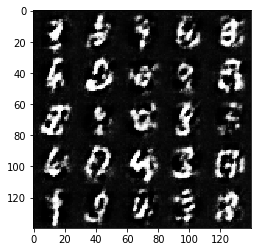

Epoch 1/2... Discriminator Loss: 1.0129... Generator Loss: 0.7295
Epoch 1/2... Discriminator Loss: 0.6290... Generator Loss: 1.2350
Epoch 1/2... Discriminator Loss: 0.6052... Generator Loss: 2.0632
Epoch 1/2... Discriminator Loss: 1.0068... Generator Loss: 0.5895
Epoch 1/2... Discriminator Loss: 0.7906... Generator Loss: 1.4380
Epoch 1/2... Discriminator Loss: 0.7854... Generator Loss: 1.0661
Epoch 1/2... Discriminator Loss: 0.8621... Generator Loss: 0.9151
Epoch 1/2... Discriminator Loss: 0.9264... Generator Loss: 0.7145
Epoch 1/2... Discriminator Loss: 1.4033... Generator Loss: 0.4116
Epoch 1/2... Discriminator Loss: 0.8830... Generator Loss: 0.9097


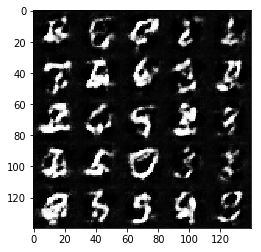

Epoch 1/2... Discriminator Loss: 1.0114... Generator Loss: 0.6459
Epoch 1/2... Discriminator Loss: 1.4349... Generator Loss: 0.3799
Epoch 1/2... Discriminator Loss: 1.6340... Generator Loss: 0.2761
Epoch 1/2... Discriminator Loss: 1.2139... Generator Loss: 0.5362
Epoch 1/2... Discriminator Loss: 0.7918... Generator Loss: 1.0516
Epoch 1/2... Discriminator Loss: 0.9802... Generator Loss: 0.7185
Epoch 1/2... Discriminator Loss: 1.4260... Generator Loss: 2.7000
Epoch 1/2... Discriminator Loss: 1.0570... Generator Loss: 0.7141
Epoch 1/2... Discriminator Loss: 1.0272... Generator Loss: 0.6884
Epoch 1/2... Discriminator Loss: 0.8882... Generator Loss: 1.0410


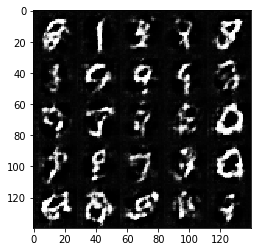

Epoch 1/2... Discriminator Loss: 0.9917... Generator Loss: 0.7618
Epoch 1/2... Discriminator Loss: 1.3131... Generator Loss: 0.3575
Epoch 1/2... Discriminator Loss: 1.5907... Generator Loss: 0.3080
Epoch 1/2... Discriminator Loss: 1.3461... Generator Loss: 0.4151
Epoch 1/2... Discriminator Loss: 1.0839... Generator Loss: 2.2074
Epoch 1/2... Discriminator Loss: 1.0667... Generator Loss: 0.7073
Epoch 1/2... Discriminator Loss: 1.1357... Generator Loss: 0.5503
Epoch 1/2... Discriminator Loss: 0.9514... Generator Loss: 1.4738
Epoch 1/2... Discriminator Loss: 0.9304... Generator Loss: 0.8439
Epoch 1/2... Discriminator Loss: 1.0045... Generator Loss: 0.9568


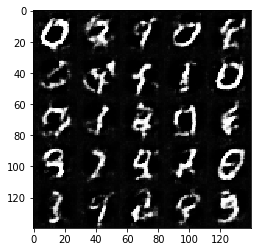

Epoch 1/2... Discriminator Loss: 1.0932... Generator Loss: 2.4561
Epoch 1/2... Discriminator Loss: 1.3364... Generator Loss: 0.3798
Epoch 1/2... Discriminator Loss: 1.7766... Generator Loss: 0.2231
Epoch 1/2... Discriminator Loss: 1.3484... Generator Loss: 0.4441
Epoch 1/2... Discriminator Loss: 0.9657... Generator Loss: 0.7945
Epoch 1/2... Discriminator Loss: 1.2609... Generator Loss: 0.4912
Epoch 1/2... Discriminator Loss: 1.4457... Generator Loss: 0.3586
Epoch 1/2... Discriminator Loss: 1.0487... Generator Loss: 1.0753
Epoch 1/2... Discriminator Loss: 1.1824... Generator Loss: 0.5169
Epoch 1/2... Discriminator Loss: 1.1945... Generator Loss: 0.4776


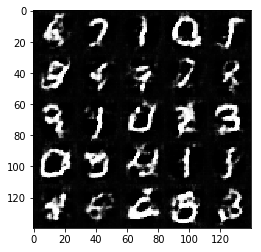

Epoch 1/2... Discriminator Loss: 0.9950... Generator Loss: 0.7888
Epoch 1/2... Discriminator Loss: 1.4206... Generator Loss: 0.3615
Epoch 1/2... Discriminator Loss: 0.9878... Generator Loss: 1.3198
Epoch 1/2... Discriminator Loss: 0.9106... Generator Loss: 1.1446
Epoch 1/2... Discriminator Loss: 1.0802... Generator Loss: 0.6293
Epoch 1/2... Discriminator Loss: 1.3760... Generator Loss: 0.4027
Epoch 1/2... Discriminator Loss: 1.2348... Generator Loss: 0.4684
Epoch 1/2... Discriminator Loss: 1.7960... Generator Loss: 0.2250


In [ ]:
batch_size = 32
z_dim = 200
learning_rate = 0.0001
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

In [36]:
batch_size = 32
z_dim = 200
learning_rate = 0.0001
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

Epoch 1/1... Discriminator Loss: 0.0244... Generator Loss: 5.3681
Epoch 1/1... Discriminator Loss: 0.0090... Generator Loss: 5.0441
Epoch 1/1... Discriminator Loss: 0.0449... Generator Loss: 3.4970
Epoch 1/1... Discriminator Loss: 0.0186... Generator Loss: 4.7481
Epoch 1/1... Discriminator Loss: 0.0051... Generator Loss: 5.9528
Epoch 1/1... Discriminator Loss: 0.0022... Generator Loss: 6.4675
Epoch 1/1... Discriminator Loss: 0.0015... Generator Loss: 6.8259
Epoch 1/1... Discriminator Loss: 0.0014... Generator Loss: 7.3704
Epoch 1/1... Discriminator Loss: 0.0006... Generator Loss: 7.9520
Epoch 1/1... Discriminator Loss: 0.0003... Generator Loss: 9.0888
Epoch 1/1... Discriminator Loss: 0.0004... Generator Loss: 8.2670
Epoch 1/1... Discriminator Loss: 0.0009... Generator Loss: 7.3879
Epoch 1/1... Discriminator Loss: 0.0007... Generator Loss: 7.6355
Epoch 1/1... Discriminator Loss: 0.0005... Generator Loss: 7.8163
Epoch 1/1... Discriminator Loss: 118.5971... Generator Loss: 0.0000
Epoch 1/

Epoch 1/1... Discriminator Loss: 0.0015... Generator Loss: 16.1740
Epoch 1/1... Discriminator Loss: 0.0022... Generator Loss: 17.0352
Epoch 1/1... Discriminator Loss: 0.0002... Generator Loss: 31.6716
Epoch 1/1... Discriminator Loss: 0.0000... Generator Loss: 14.5610
Epoch 1/1... Discriminator Loss: 0.0038... Generator Loss: 8.8432
Epoch 1/1... Discriminator Loss: 0.0000... Generator Loss: 12.6573
Epoch 1/1... Discriminator Loss: 0.0002... Generator Loss: 59.2650
Epoch 1/1... Discriminator Loss: 0.0033... Generator Loss: 6.6565
Epoch 1/1... Discriminator Loss: 0.0021... Generator Loss: 8.7266
Epoch 1/1... Discriminator Loss: 0.0002... Generator Loss: 87.2689
Epoch 1/1... Discriminator Loss: 0.0000... Generator Loss: 28.9051
Epoch 1/1... Discriminator Loss: 0.0034... Generator Loss: 6.3410
Epoch 1/1... Discriminator Loss: 0.0002... Generator Loss: 81.1422


KeyboardInterrupt: 

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.